<a href="https://colab.research.google.com/github/Ejay123-tech/LLMs/blob/main/Kilimo_Smart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pest and Disease Management in Legume Farming in Kenya**

To improve pest and disease management in legume farming by integrating structured weather data with unstructured farmer-generated reports, enabling timely and data-driven recommendations for farmers and agricultural stakeholders in Kenya.

The findings are expected to support farmers and agricultural stakeholders in making informed decisions around planting, pest control, and climate adaptation, with the broader goal of enhancing food security and sustainable agriculture.

In [2]:
# Install required libraries
!pip install nltk wordcloud

# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error


In [3]:
import nltk
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error

nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#✅ **Goal**:
Build a pipeline that:

* Cleans & merges the datasets

* Extracts insights from text

*  Predicts:

* Disease outbreak (Classification)

* Crop yield (Regression)

* Visualizes relationships

* Make Inferences




In [5]:
# Simulation settings
n = 10000  # number of rows
counties = ["Nakuru", "Uasin Gishu", "Embu", "Bungoma", "Meru", "Kisii", "Nyeri", "Machakos"]

# Simulate data
np.random.seed(42)
data = {
    "date": pd.date_range("2023-01-01", periods=n, freq="D").to_series().sample(n, replace=True).sort_values().values,
    "county": np.random.choice(counties, n),
    "temperature_max": np.random.normal(28, 4, n).round(1),
    "temperature_min": np.random.normal(16, 3, n).round(1),
    "rainfall_mm": np.random.exponential(10, n).round(1),
    "humidity_%": np.random.normal(60, 10, n).clip(30, 90),
    "soil_moisture_%": np.random.uniform(10, 60, n).round(1),
    "wind_speed_kmph": np.random.normal(10, 3, n).round(1),
    "pest_infestation": np.random.choice(["low", "medium", "high"], n, p=[0.6, 0.3, 0.1]),
    "disease_outbreak": np.random.choice(["no", "yes"], n, p=[0.85, 0.15]),
}

df_weather = pd.DataFrame(data)

In [7]:
# Simulate crop yield (inverse relation with pest/disease, positive with rainfall & soil moisture)
def yield_estimate(row):
    base = 1000
    modifier = 1
    if row["pest_infestation"] == "medium": modifier -= 0.2
    elif row["pest_infestation"] == "high": modifier -= 0.5
    if row["disease_outbreak"] == "yes": modifier -= 0.3
    modifier += row["rainfall_mm"] / 200 + row["soil_moisture_%"] / 100
    return max(300, round(base * modifier, 1))

df_weather["crop_yield_estimate_kg_per_acre"] = df_weather.apply(yield_estimate, axis=1)

df_weather.head()


,date,county,temperature_max,temperature_min,rainfall_mm,humidity_%,soil_moisture_%,wind_speed_kmph,pest_infestation,disease_outbreak,crop_yield_estimate_kg_per_acre
0,2023-01-02,Nakuru,25.0,15.2,22.7,57.009767,49.3,6.2,high,no,1106.5
1,2023-01-02,Nyeri,30.6,19.3,2.0,57.768709,43.5,15.6,low,no,1445.0
2,2023-01-02,Nakuru,33.5,18.9,6.5,58.474049,15.9,8.2,low,no,1191.5
3,2023-01-03,Nakuru,28.8,19.3,10.0,41.955913,15.9,7.9,medium,yes,709.0
4,2023-01-03,Nakuru,31.6,15.3,7.3,63.772836,36.9,14.2,low,no,1405.5


In [14]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             10000 non-null  datetime64[ns]
 1   county                           10000 non-null  object        
 2   temperature_max                  10000 non-null  float64       
 3   temperature_min                  10000 non-null  float64       
 4   rainfall_mm                      10000 non-null  float64       
 5   humidity_%                       10000 non-null  float64       
 6   soil_moisture_%                  10000 non-null  float64       
 7   wind_speed_kmph                  10000 non-null  float64       
 8   pest_infestation                 10000 non-null  object        
 9   disease_outbreak                 10000 non-null  object        
 10  crop_yield_estimate_kg_per_acre  10000 non-null  float64   

In [15]:
text_data = []
pests = ["aphids", "cutworms", "bean weevils", "leaf miners"]
diseases = ["leaf rust", "root rot", "blight", "fungal infections"]
issues = ["too much rain", "long dry spells", "very cold mornings", "hot afternoons"]
actions = ["sprayed pesticide", "consulted extension officer", "lost some crops", "waiting for rainfall"]

for _ in range(3000):
    date = pd.to_datetime(np.random.choice(df_weather["date"]))
    county = np.random.choice(counties)
    problem = np.random.choice(pests + diseases + issues)
    action = np.random.choice(actions)
    text = f"In {county}, {problem} affected our. We {action}."
    text_data.append({"date": date, "county": county, "text_report": text})

df_text = pd.DataFrame(text_data)
df_text.head()


,date,county,text_report
0,2049-09-23,Machakos,"In Machakos, bean weevils affected our. We wai..."
1,2046-06-07,Meru,"In Meru, bean weevils affected our. We sprayed..."
2,2050-03-05,Machakos,"In Machakos, blight affected our. We sprayed p..."
3,2026-04-07,Uasin Gishu,"In Uasin Gishu, long dry spells affected our. ..."
4,2047-09-27,Machakos,"In Machakos, cutworms affected our. We consult..."


In [12]:
df_text.shape

(3000, 3)

# Data Preprocssing

In [ ]:
# Total Crop yield by county
df.groupby("county")["crop_yield_estimate_kg_per_acre"].mean()



,crop_yield_estimate_kg_per_acre
county,
Bungoma,1261.837912
Embu,1235.616438
Kisii,1247.365492
Machakos,1241.649452
Meru,1239.233491
Nakuru,1255.290939
Nyeri,1253.952363
Uasin Gishu,1252.799839


<Axes: xlabel='rainfall_mm', ylabel='crop_yield_estimate_kg_per_acre'>

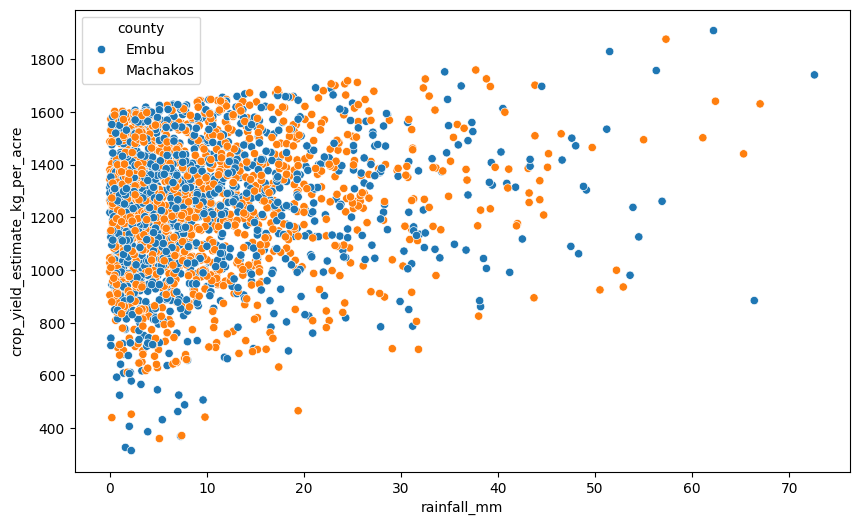

In [ ]:
# Rainfall vs crop yield for machakos and embu
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df["county"].isin(["Machakos", "Embu"])], x="rainfall_mm", y="crop_yield_estimate_kg_per_acre", hue="county")


In [ ]:
df_merged = pd.merge(df_weather, df_text, on=["date", "county"], how="left")
df_merged.fillna({"pest_mention": 0, "disease_mention": 0, "climate_issue": 0}, inplace=True)


<Axes: xlabel='temperature_max', ylabel='crop_yield_estimate_kg_per_acre'>

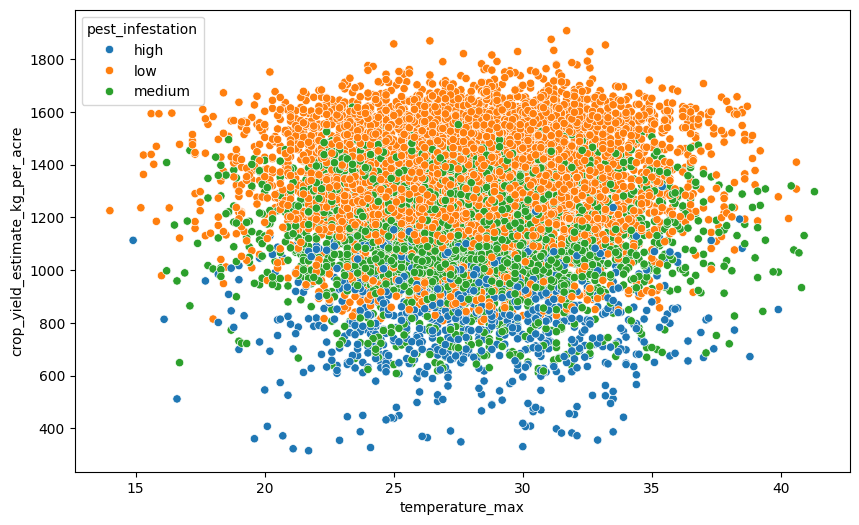

In [ ]:
# Temperature vs disease infestation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="temperature_max", y="crop_yield_estimate_kg_per_acre", hue="pest_infestation")

<Axes: xlabel='disease_outbreak', ylabel='crop_yield_estimate_kg_per_acre'>

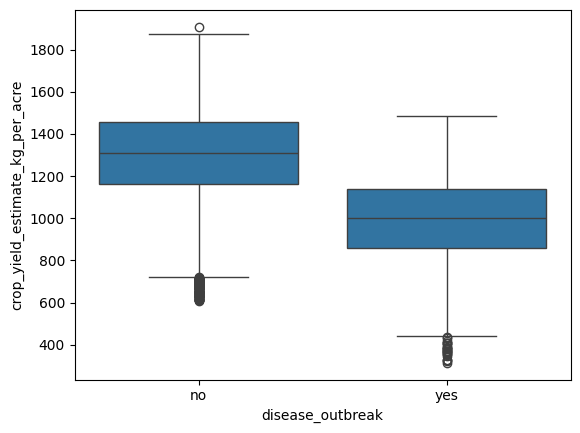

In [ ]:
# How disease affect yield
sns.boxplot(data=df, x="disease_outbreak", y="crop_yield_estimate_kg_per_acre")

In [ ]:
df.info(), text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             10000 non-null  datetime64[ns]
 1   county                           10000 non-null  object        
 2   temperature_max                  10000 non-null  float64       
 3   temperature_min                  10000 non-null  float64       
 4   rainfall_mm                      10000 non-null  float64       
 5   humidity_%                       10000 non-null  float64       
 6   soil_moisture_%                  10000 non-null  float64       
 7   wind_speed_kmph                  10000 non-null  float64       
 8   pest_infestation                 10000 non-null  object        
 9   disease_outbreak                 10000 non-null  object        
 10  crop_yield_estimate_kg_per_acre  10000 non-null  float64   

(None, None)

<Axes: xlabel='date', ylabel='crop_yield_estimate_kg_per_acre'>

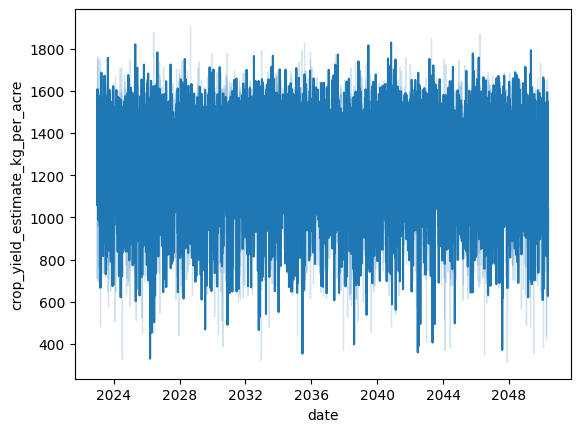

In [ ]:
# lineplot for yield relationship with rainfall
sns.lineplot(data=df_weather, x="date", y="crop_yield_estimate_kg_per_acre")


In [17]:
import pandas as pd
import random
from datetime import datetime, timedelta

# Seed for reproducibility
random.seed(42)

# Sample data
counties = ["Kiambu", "Murang'a", "Bungoma", "Meru", "Nyeri", "Embu", "Kisii"]
crops = {
    "Maize": {
        "diseases": ["Maize Streak Virus", "Northern Leaf Blight", "Grey Leaf Spot"],
        "pests": ["Fall Armyworm", "Stem Borer"],
        "symptoms": ["Yellowing leaves", "Leaf lesions", "Stunted growth"],
        "solutions": ["Apply insecticide", "Crop rotation", "Use certified seeds"]
    },
    "Beans": {
        "diseases": ["Angular Leaf Spot", "Root Rot", "Bean Rust"],
        "pests": ["Bean Aphid", "Whitefly"],
        "symptoms": ["Brown patches", "Leaf curling", "Powdery mildew"],
        "solutions": ["Use fungicide", "Improve drainage", "Use resistant varieties"]
    },
    "Coffee": {
        "diseases": ["Coffee Leaf Rust", "Coffee Berry Disease", "Root Knot Nematode"],
        "pests": ["Coffee Borer Beetle", "Green Scale"],
        "symptoms": ["Orange leaf spots", "Berry drop", "Root swelling"],
        "solutions": ["Apply copper fungicide", "Prune infected branches", "Soil treatment"]
    }
}

# Generate dataset
data = []
start_date = datetime(2025, 4, 1)

for i in range(30):  # 10 entries per crop
    crop_type = random.choice(list(crops.keys()))
    disease = random.choice(crops[crop_type]["diseases"])
    pest = random.choice(crops[crop_type]["pests"])
    symptom = random.choice(crops[crop_type]["symptoms"])
    solution = random.choice(crops[crop_type]["solutions"])
    note = random.choice(["Spotted early", "Severe infestation", "Farmer unsure", "Occurred after rain"])

    entry = {
        "date": (start_date + timedelta(days=i)).strftime("%Y-%m-%d"),
        "county": random.choice(counties),
        "crop_type": crop_type,
        "disease_name": disease,
        "pest_name": pest,
        "symptoms": symptom,
        "recommended_solution": solution,
        "farm_notes": note
    }
    data.append(entry)

# Create DataFrame and save to CSV
crops_data = pd.DataFrame(data)
crops_data.to_csv("simulated_farm_data.csv", index=False)

print("Simulated dataset saved as 'simulated_farm_data.csv'")


Simulated dataset saved as 'simulated_farm_data.csv'


In [18]:
crops_data.head()

,date,county,crop_type,disease_name,pest_name,symptoms,recommended_solution,farm_notes
0,2025-04-01,Murang'a,Coffee,Coffee Leaf Rust,Coffee Borer Beetle,Root swelling,Prune infected branches,Severe infestation
1,2025-04-02,Nyeri,Maize,Grey Leaf Spot,Fall Armyworm,Stunted growth,Use certified seeds,Spotted early
2,2025-04-03,Nyeri,Beans,Angular Leaf Spot,Bean Aphid,Brown patches,Use fungicide,Severe infestation
3,2025-04-04,Murang'a,Coffee,Coffee Leaf Rust,Coffee Borer Beetle,Root swelling,Soil treatment,Occurred after rain
4,2025-04-05,Bungoma,Beans,Bean Rust,Whitefly,Brown patches,Use fungicide,Occurred after rain


In [20]:
import kagglehub

In [21]:
#import kagglehub

# Download latest version
path = kagglehub.dataset_download("alvarole/coffee-leaves-disease")

print("Path to dataset files:", path)

100%|██████████| 1.40G/1.40G [00:15<00:00, 96.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    stop_words = set(stopwords.words("english"))
    return " ".join([w for w in text.split() if w not in stop_words])

df_text["cleaned_text"] = df_text["text_report"].apply(clean_text)

# Keyword tagging
def tag_keywords(text):
    return pd.Series({
        "pest_mention": int(any(w in text for w in ["aphid", "weevil", "worm", "locust"])),
        "disease_mention": int(any(w in text for w in ["blight", "fungus", "rot", "rust"])),
        "climate_issue": int(any(w in text for w in ["drought", "flood", "dry", "heavy rain"]))
    })

df_tags = df_text["cleaned_text"].apply(tag_keywords)
df_text = pd.concat([df_text, df_tags], axis=1)


In [23]:
# Path to dataset files: /root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1
# This is a comment and not Python code, so no syntax error to fix.
# If you need to use this path in your code, you can assign it to a variable like so:
dataset_path = "/root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1"

In [24]:
import os

data_dir = "/root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1"

# List top-level folders/files
for item in os.listdir(data_dir):
    print(item)


rust_xml_image
miner_img_xml


In [27]:
data_dir = "/root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1"

In [29]:
import os

data_dir = "/root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1"

# Recursively walk through the structure
for root, dirs, files in os.walk(data_dir):
    print(f"Directory: {root}")
    for d in dirs:
        print("  Subfolder:", d)
    for f in files[:5]:  # show first 5 files if too many
        print("  File:", f)
    print("-" * 50)



Directory: /root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1
  Subfolder: rust_xml_image
  Subfolder: miner_img_xml
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1/rust_xml_image
  File: name53.jpg
  File: name21.jpg
  File: name255.jpg
  File: name308.jpg
  File: name238.xml
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1/miner_img_xml
  File: bicho_mineiro125.xml
  File: bicho_mineiro99.jpg
  File: bicho_mineiro227.xml
  File: bicho_mineiro38.jpg
  File: bicho_mineiro97.xml
--------------------------------------------------


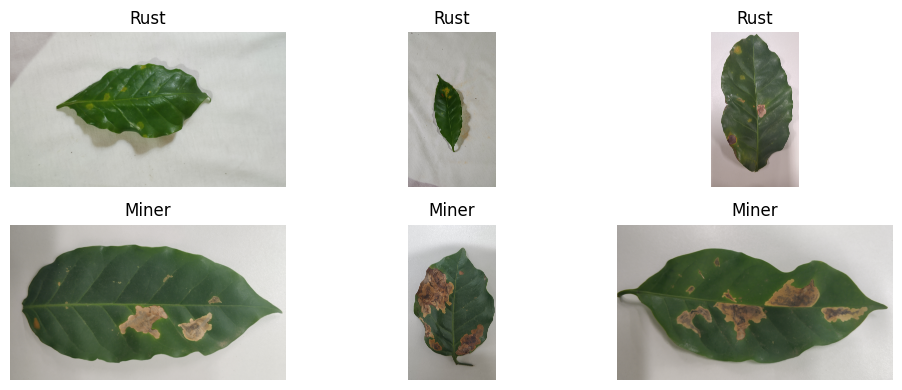

In [33]:
import matplotlib.pyplot as plt
import cv2
import os

# Define folder paths
rust_path = os.path.join(data_dir, "rust_xml_image")
miner_path = os.path.join(data_dir, "miner_img_xml")

# Pick a few rust images
rust_images = [f for f in os.listdir(rust_path) if f.endswith(".jpg")]
miner_images = [f for f in os.listdir(miner_path) if f.endswith(".jpg")]

# Plot samples
plt.figure(figsize=(10, 4))

for i in range(3):
    rust_img = cv2.imread(os.path.join(rust_path, rust_images[i]))
    rust_img = cv2.cvtColor(rust_img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(rust_img)
    plt.title("Rust")
    plt.axis('off')

    miner_img = cv2.imread(os.path.join(miner_path, miner_images[i]))
    miner_img = cv2.cvtColor(miner_img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+4)
    plt.imshow(miner_img)
    plt.title("Miner")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [35]:
import os
import shutil

# Define your base directory for organized images
base_dir = "/content/coffee_diseases"
os.makedirs(base_dir, exist_ok=True)

# Define subfolders
rust_path = "/root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1/rust_xml_image"
miner_path = "/root/.cache/kagglehub/datasets/alvarole/coffee-leaves-disease/versions/1/miner_img_xml"

os.makedirs(os.path.join(base_dir, "rust"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "miner"), exist_ok=True)

# Copy image files
rust_images = [f for f in os.listdir(rust_path) if f.endswith(".jpg")]
miner_images = [f for f in os.listdir(miner_path) if f.endswith(".jpg")]

for f in rust_images:
    shutil.copy(os.path.join(rust_path, f), os.path.join(base_dir, "rust", f))

for f in miner_images:
    shutil.copy(os.path.join(miner_path, f), os.path.join(base_dir, "miner", f))

print("✅ Images organized in:", base_dir)


✅ Images organized in: /content/coffee_diseases


In [36]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'  # or 'int' if you prefer integer labels
)


Found 542 files belonging to 2 classes.


In [37]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize pixel values

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  # 2 classes: rust and miner
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compiling the model

In [38]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Optional: Performance boost
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 542 files belonging to 2 classes.
Using 434 files for training.
Found 542 files belonging to 2 classes.
Using 108 files for validation.


In [41]:
# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5333 - loss: 1.0251 - val_accuracy: 0.6944 - val_loss: 0.6512
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.8443 - loss: 0.3935 - val_accuracy: 0.8981 - val_loss: 0.2662
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.9125 - loss: 0.2330 - val_accuracy: 0.8981 - val_loss: 0.2198
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9340 - loss: 0.1595 - val_accuracy: 0.9722 - val_loss: 0.0913
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9706 - loss: 0.0768 - val_accuracy: 0.9815 - val_loss: 0.0803
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9722 - loss: 0.0659 - val_accuracy: 0.9722 - val_loss: 0.1104
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9846 - loss: 0.0506 - val_accuracy: 0.9815 - val_loss: 0.0675
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9917 - loss: 0.0193 - val_accuracy: 0.9815 - val_loss:

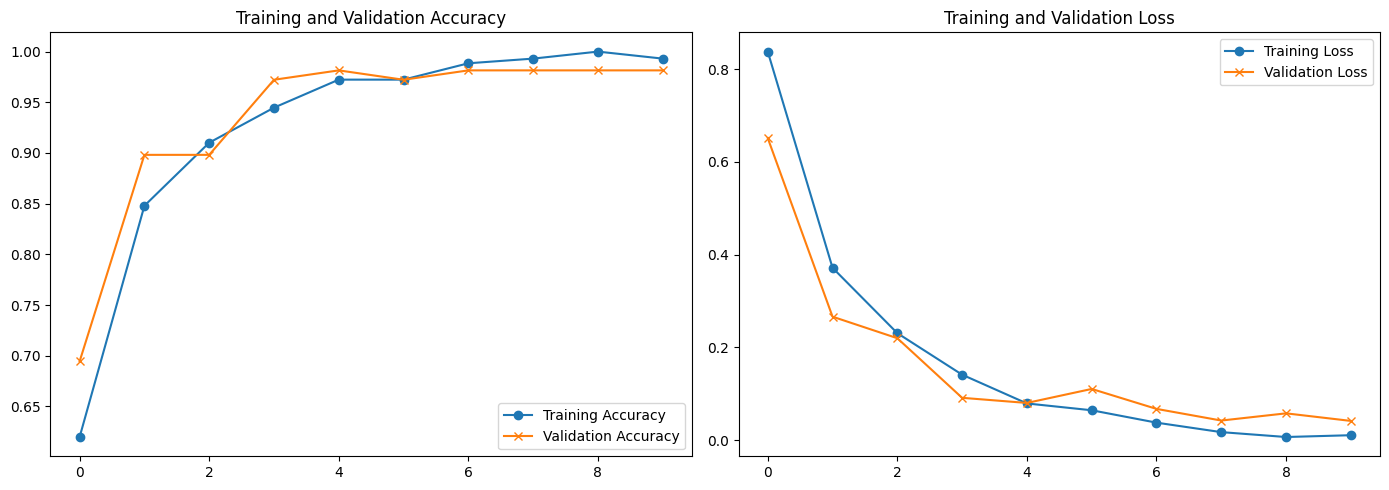

In [42]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [ ]:
df_merged["temp_range"] = df_merged["temperature_max"] - df_merged["temperature_min"]
df_merged["rain_above_20mm"] = (df_merged["rainfall_mm"] > 20).astype(int)

# Convert targets to numeric
df_merged["pest_infestation"] = df_merged["pest_infestation"].map({"yes": 1, "no": 0})
df_merged["disease_outbreak"] = df_merged["disease_outbreak"].map({"yes": 1, "no": 0})


### Modelling Disease Outbreak

In [ ]:
X = df_merged[[
    "temperature_max", "rainfall_mm", "humidity_%", "soil_moisture_%",
    "wind_speed_kmph", "pest_mention", "climate_issue"
]]
y = df_merged["disease_outbreak"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1689
           1       1.00      0.01      0.01       318

    accuracy                           0.84      2007
   macro avg       0.92      0.50      0.46      2007
weighted avg       0.87      0.84      0.77      2007



### Modeling Crops Yields

In [ ]:
X = df_merged[[
    "temperature_max", "rainfall_mm", "humidity_%", "soil_moisture_%",
    "pest_infestation", "disease_mention", "climate_issue"
]]
y = df_merged["crop_yield_estimate_kg_per_acre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))


MSE: 40795.89151509716


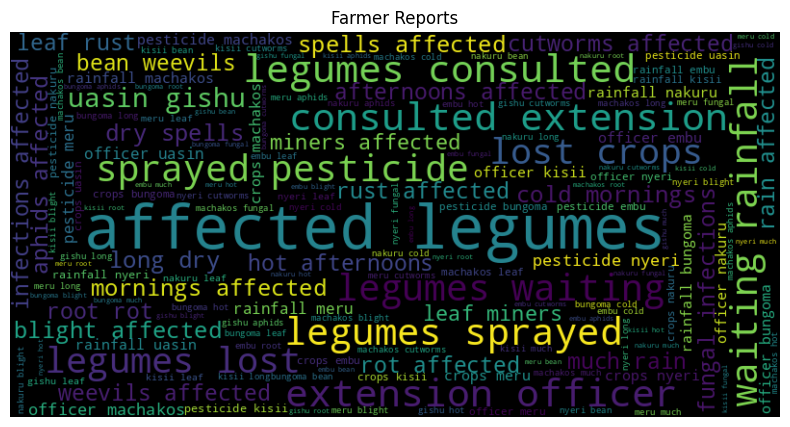

In [ ]:
# WordCloud
text_all = " ".join(df_text["cleaned_text"])
wc = WordCloud(width=800, height=400).generate(text_all)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Farmer Reports")
plt.show()




In [ ]:
!pip install textblob

from textblob import TextBlob


In [ ]:
# Apply sentiment analysis
df_text["polarity"] = df_text["cleaned_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_text["subjectivity"] = df_text["cleaned_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Categorize sentiment
def label_sentiment(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df_text["sentiment"] = df_text["polarity"].apply(label_sentiment)


<ipython-input-45-943b8867bc3e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_text, x="sentiment", palette="coolwarm")


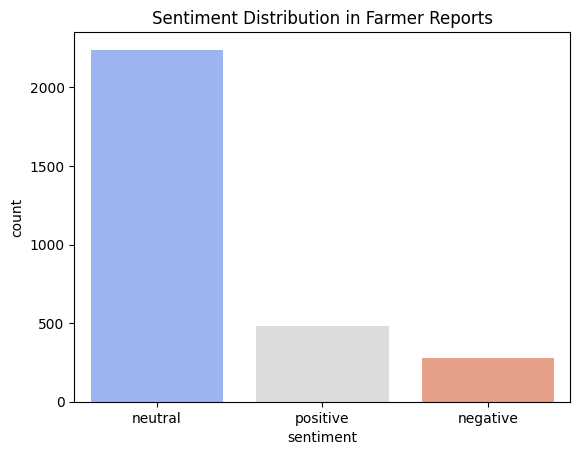

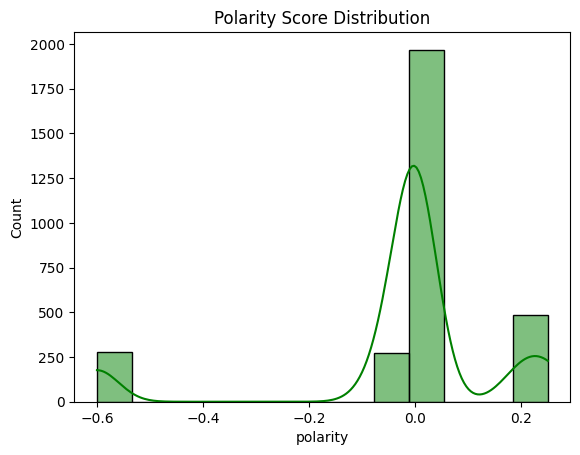

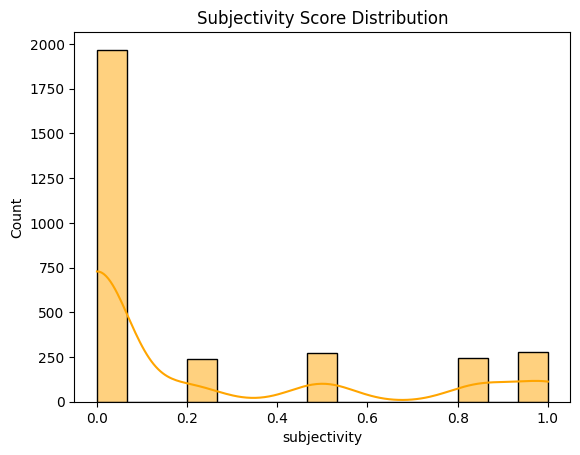

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of sentiments
sns.countplot(data=df_text, x="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution in Farmer Reports")
plt.show()

# Polarity and Subjectivity
sns.histplot(df_text["polarity"], kde=True, color="green")
plt.title("Polarity Score Distribution")
plt.show()

sns.histplot(df_text["subjectivity"], kde=True, color="orange")
plt.title("Subjectivity Score Distribution")
plt.show()


In [ ]:
df_merged = pd.merge(df_weather, df_text[["date", "county", "sentiment", "polarity", "subjectivity"]],
                     on=["date", "county"], how="left")


<ipython-input-48-566885ecdd0f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x="sentiment", y="crop_yield_estimate_kg_per_acre", palette="Set2")


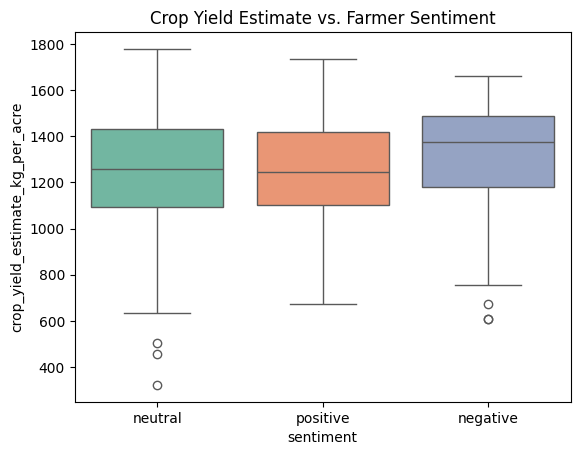

In [ ]:
sns.boxplot(data=df_merged, x="sentiment", y="crop_yield_estimate_kg_per_acre", palette="Set2")
plt.title("Crop Yield Estimate vs. Farmer Sentiment")
plt.show()


In [ ]:
!pip install datasets
from datasets import load_dataset

ds = load_dataset("Rahulrayudu/Crop_QA_Dataset")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/311 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset

ds = load_dataset("Rahulrayudu/Crop_QA_Dataset")

In [ ]:
!pip install tokenizers datasets


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"

# We call define a model object
model = AutoModelForSequenceClassification.from_pretrained(model_name)




config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

In [ ]:
!pip install flask


In [ ]:
import joblib

# Save model
joblib.dump(model, 'legume_model.pkl')


['legume_model.pkl']

In [ ]:
!pip install flask-ngrok
!pip install pyngrok
!pip install joblib


In [ ]:
import joblib

# Assume your model is trained and stored in `model`
joblib.dump(model, 'legume_model.pkl')


['legume_model.pkl']

In [ ]:
from flask import Flask, request, render_template_string
from flask_ngrok import run_with_ngrok
import joblib

app = Flask(__name__)
run_with_ngrok(app)  # Use ngrok to make it accessible

# Load the saved model
model = joblib.load('legume_model.pkl')

# HTML Template
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Legume Farming Predictor</title>
</head>
<body>
    <h2>Pest and Disease Prediction in Legume Farming</h2>
    <form method="post">
        <label>Temperature (°C):</label><br>
        <input type="text" name="temperature"><br><br>

        <label>Rainfall (mm):</label><br>
        <input type="text" name="rainfall"><br><br>

        <label>Humidity (%):</label><br>
        <input type="text" name="humidity"><br><br>

        <input type="submit" value="Predict">
    </form>

    {% if prediction %}
        <h3>Prediction: {{ prediction }}</h3>
    {% endif %}
</body>
</html>
"""

@app.route('/', methods=['GET', 'POST'])
def home():
    prediction = None
    if request.method == 'POST':
        try:
            temp = float(request.form['temperature'])
            rain = float(request.form['rainfall'])
            hum = float(request.form['humidity'])
            prediction = model.predict([[temp, rain, hum]])[0]
        except Exception as e:
            prediction = f"Error: {str(e)}"
    return render_template_string(HTML_TEMPLATE, prediction=prediction)

# Start the Flask app
app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
           

In [ ]:
<!DOCTYPE html>
<html>
<head>
    <title>Legume Farming Predictor</title>
</head>
<body>
    <h2>Pest and Disease Prediction in Legume Farming</h2>
    <form action="/predict" method="post">
        <label>Temperature (°C):</label><br>
        <input type="text" name="temperature"><br><br>

        <label>Rainfall (mm):</label><br>
        <input type="text" name="rainfall"><br><br>

        <label>Humidity (%):</label><br>
        <input type="text" name="humidity"><br><br>

        <input type="submit" value="Predict">
    </form>

    <h3>{{ prediction_text }}</h3>
</body>
</html>


In [ ]:
!pip install flask-ngrok
!pip install joblib


In [ ]:
from flask import Flask, request, render_template_string
from flask_ngrok import run_with_ngrok
import joblib

app = Flask(__name__)
run_with_ngrok(app)

# Load your model
model = joblib.load("legume_model.pkl")

# HTML page
HTML_PAGE = """
<!DOCTYPE html>
<html>
<head>
  <title>Legume Farming Prediction</title>
</head>
<body>
  <h2>Pest and Disease Predictor for Legume Farms</h2>
  <form method="post">
    <label>Temperature (°C):</label><br>
    <input type="text" name="temperature"><br><br>

    <label>Rainfall (mm):</label><br>
    <input type="text" name="rainfall"><br><br>

    <label>Humidity (%):</label><br>
    <input type="text" name="humidity"><br><br>

    <input type="submit" value="Predict">
  </form>

  {% if prediction %}
    <h3>Prediction: {{ prediction }}</h3>
  {% endif %}
</body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def predict():
    prediction = None
    if request.method == "POST":
        try:
            temperature = float(request.form["temperature"])
            rainfall = float(request.form["rainfall"])
            humidity = float(request.form["humidity"])
            data = [[temperature, rainfall, humidity]]
            prediction = model.predict(data)[0]
        except Exception as e:
            prediction = f"Error: {str(e)}"
    return render_template_string(HTML_PAGE, prediction=prediction)

app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
           

In [ ]:
import joblib

# Save the model as legume_model.pkl
joblib.dump(model, 'legume_model.pkl')


['legume_model.pkl']

In [ ]:
!pip install flask-ngrok
!pip install joblib


In [ ]:
from flask import Flask, request, render_template_string
from flask_ngrok import run_with_ngrok
import joblib

app = Flask(__name__)
run_with_ngrok(app)

# Load your model
model = joblib.load("legume_model.pkl")

# HTML page
HTML_PAGE = """
<!DOCTYPE html>
<html>
<head>
  <title>Legume Farming Prediction</title>
</head>
<body>
  <h2>Pest and Disease Predictor for Legume Farms</h2>
  <form method="post">
    <label>Temperature (°C):</label><br>
    <input type="text" name="temperature"><br><br>

    <label>Rainfall (mm):</label><br>
    <input type="text" name="rainfall"><br><br>

    <label>Humidity (%):</label><br>
    <input type="text" name="humidity"><br><br>

    <input type="submit" value="Predict">
  </form>

  {% if prediction %}
    <h3>Prediction: {{ prediction }}</h3>
  {% endif %}
</body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def predict():
    prediction = None
    if request.method == "POST":
        try:
            temperature = float(request.form["temperature"])
            rainfall = float(request.form["rainfall"])
            humidity = float(request.form["humidity"])
            data = [[temperature, rainfall, humidity]]
            prediction = model.predict(data)[0]
        except Exception as e:
            prediction = f"Error: {str(e)}"
    return render_template_string(HTML_PAGE, prediction=prediction)

app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
           